## PyTorch Examples:

Basic tutorials and examples for different functions of PyTorch.

In [187]:
# Imports 
import torch 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torchvision
import torchvision.transforms as transforms

sns.set_palette('muted',color_codes=True)
sns.set_context('paper')
%matplotlib inline

##### Tensors and basics:

Any in place mutation is the function with an additional "\_" affixed to the end. i.e add() -> add\_()

In [36]:
def histplot(histc,color='b'):
    """ Takes in a torch histc Tensor and plots a seaborn distplot based on the bins"""
    nbins = histc.size()[0]
    x = []
    for n in range(nbins):
        x.append('bin_{}'.format(n))
    sns.barplot(y=histc,x=x,color=color)
    sns.despine()

Size: torch.Size([5, 3])

-0.4554 -1.2981 -0.2544  0.0985  0.6190
 0.3953 -2.2400 -0.8150  0.2968 -0.8265
 1.0408 -1.1926  1.0119  0.1814  1.2837
-0.4874  0.2415  0.1989 -0.3337  0.4727
-1.6842  0.0877 -1.4097  0.1202 -0.2659
[torch.FloatTensor of size 5x5]



/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


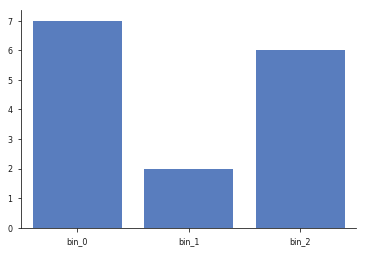

In [199]:
torch.Tensor(5,3) # uninit tensor
x = torch.rand(5,3)
print('Size:',x.size())
y = torch.rand(5,3)
q = torch.histc(y,bins=3,min=0,max=1) # cuts the tensor into specified bins and plots with function below
histplot(q)
z = x+y # matrix addition
z = torch.mm(x,y.transpose(0,1)) # matrix multiplication
zo2 = torch.div(x,2.2) # elementwise value division 
z9 = torch.mul(x,9) # elementwise value multiply 
zy = torch.mul(x,y) # elementwise tensor multiplication (also given by the * operator, x*y==zy)
x_1 = torch.randn(2, 5)
y_1 = torch.randn(3, 5)
z_1 = torch.cat([x_1, y_1])
print(z_1)

In [91]:
# Torch distributions
torch.manual_seed(1002) # setting the random seed
rand_normal = torch.randn(2,5)
vec = torch.arange(1,10,.5)
a = torch.Tensor(5,3).uniform_(0,1) # min, max 
b = torch.Tensor(5,3).uniform_(0,10) # min, max 
c = torch.Tensor(5,3).normal_(3,8) # mean, std 
d = torch.bernoulli(a) # assigns bernoulli with probabilities given in matrix a
e = torch.normal(vec,3.2) # means and one std
f = torch.normal(2.1,vec) # mean and vec of stds
g = torch.normal(vec,torch.arange(10,1,-.5)) # vector of means and vector of stds
gn = g.numpy() # Make the FloatTensor a numpy ndarray
vb = torch.var(b) # gets the variance of a FloatTensor (expected 10)
n1 = np.ones(10)
t1 = torch.from_numpy(n1)
# print(n1)
# print(t1)
""" Normalizes the input rows to be a probability distribution and treats the inputs as weights, returning
    the indices drawn from the probability distribution in each row with the associated probability.  Default
    does not resample, leading to even 0 probability events being chosen, but setting replacement=True flag 
    bootstraps from the row-wise distributions"""
mn1 = torch.multinomial(b,2) # multinomial (gen of binomial) without resampling
mn2 = torch.multinomial(b,6,replacement=True)
mn2


 1  1  0  1  0  1
 1  2  0  2  2  2
 1  0  1  2  1  1
 1  1  1  2  2  1
 1  1  1  1  1  2
[torch.LongTensor of size 5x6]

##### PyTorch Autograd:

The most important objects are Variables and Functions. Variables wrap Tensors and Functions are referenced in Variables as .grad_fn and they represent the function that made the Variable. Variables created by user have .grad_fn = None.

In [123]:
# Autograd 
v = Variable(torch.ones(2,2),requires_grad=True)
print('Notice there is no gradient now:',v.grad)
print('Initial has no grad because I made it: ',v.grad_fn)
v2 = v+2
print('Second has a creating function: ',v2.grad_fn)
v3 = v2*v2*3
out = v3.mean()
print('Third has a creating function: ', v3.grad_fn)
out.backward(torch.Tensor([2.1])) # backprops over the whole graph to get back to the leaf (only works bc out is scalar)
print('Now there is a gradient:',v.grad)

Notice there is no gradient now: None
Initial has no grad because I made it:  None
Second has a creating function:  <AddBackward0 object at 0x127b09588>
Third has a creating function:  <MulBackward0 object at 0x127b09668>
Now there is a gradient: Variable containing:
 9.4500  9.4500
 9.4500  9.4500
[torch.FloatTensor of size 2x2]



In [126]:
torch.manual_seed(1920)
rv = Variable(torch.randn(4),requires_grad=True)
print(rv)
rv2 = rv*3
while rv2.data.norm()<1000:
    rv2 = rv2 * 2
print(rv2)

grads = torch.FloatTensor([1.5,.1,.1,.0011])
rv2.backward(grads)
print(rv.grad)

Variable containing:
 1.6918
 2.2049
 0.3538
 0.0134
[torch.FloatTensor of size 4]

Variable containing:
 649.6390
 846.6985
 135.8650
   5.1299
[torch.FloatTensor of size 4]

Variable containing:
 576.0000
  38.4000
  38.4000
   0.4224
[torch.FloatTensor of size 4]



##### PyTorch Neural Networks:

Basic nn with convolutional layers, max pooling and relu transition functions 

In [168]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # Define the layers of the network:
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # max pooling on a 2,2 2d window
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        # same thing as above 
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


##### Notes:
You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd. You can use any of the Tensor operations in the forward function.

If you have a single variable (and not a mini-batch), just use input.unsqueeze(0)

In [169]:
# The learnable parameters
from functools import reduce
params = list(net.parameters())
print(len(params))
print(params[0].size()) 

tot = 0
for p in params:
    tot+=reduce(lambda x,y: x*y, p.size())
print('Total learnable parameters:',tot)

10
torch.Size([6, 1, 5, 5])
Total learnable parameters: 61706


In [172]:
inpt = Variable(torch.randn([1,1,32,32]))
out = net(inpt)
print(out)

net.zero_grad()
out.backward(torch.randn([1,10]))

Variable containing:
 0.0509 -0.1065  0.0100 -0.1165  0.1113 -0.0402 -0.0552  0.0047 -0.0047  0.0382
[torch.FloatTensor of size 1x10]



In [179]:
outp = net(inpt)
ex_tar = Variable(torch.arange(1,11,1))
ex_criterion = nn.MSELoss()

loss = ex_criterion(outp,ex_tar)
print(loss)

print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

Variable containing:
 37.9665
[torch.FloatTensor of size 1]

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
-0.0412
-0.1619
-0.0199
-0.0742
-0.0201
-0.0242
[torch.FloatTensor of size 6]



In [176]:
# Weight updates - simple
learning_rate = 0.01
for p in net.parameters():
    p.data.sub_(p.grad.data * learning_rate)

In [182]:
# Weight updates - realistic

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
outpt = net(inpt)
loss = ex_criterion(outpt, ex_tar)
loss.backward()
optimizer.step()  

##### Get some data CIFAR10 image dataset

In [188]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


 ship  ship  bird truck


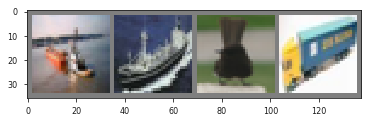

In [189]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [191]:

class Nnet(nn.Module):
    def __init__(self):
        super(Nnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


nnet = Nnet()

In [192]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.213
[1,  4000] loss: 1.902
[1,  6000] loss: 1.722
[1,  8000] loss: 1.619
[1, 10000] loss: 1.547
[1, 12000] loss: 1.490
[2,  2000] loss: 1.431
[2,  4000] loss: 1.394
[2,  6000] loss: 1.377
[2,  8000] loss: 1.336
[2, 10000] loss: 1.304
[2, 12000] loss: 1.308
Finished Training


GroundTruth:    cat  ship  ship plane
Predicted:    cat plane truck plane


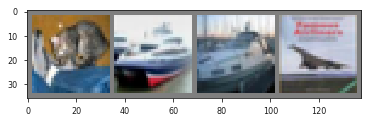

In [196]:
# Now test to see if the network learned anything 
dataiter = iter(testloader)
images, labels = dataiter.next()
    
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [197]:
# Accuracy on the entire dataset
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


In [198]:
# Accuracy by class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 45 %
Accuracy of  bird : 23 %
Accuracy of   cat : 43 %
Accuracy of  deer : 58 %
Accuracy of   dog : 42 %
Accuracy of  frog : 59 %
Accuracy of horse : 67 %
Accuracy of  ship : 40 %
Accuracy of truck : 71 %
